In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
import numpy as np

2023-05-25 15:09:24.151491: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12


In [2]:
ds = tfds.load('cifar10', split='test').shuffle(1000)
# ds = tfds.load('stl10', split='test')
one = tfds.as_numpy(ds)

2023-05-25 15:09:25.520128: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcuda.so.1
2023-05-25 15:09:25.563990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 15:09:25.564152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.785
pciBusID: 0000:08:00.0
2023-05-25 15:09:25.564185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-25 15:09:25.564326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 1 with properties: 
name: NVIDIA TITAN RTX major: 7 minor: 5 memoryClockRate(GHz): 1.77
pciBusID: 0000

In [14]:
def _enhance(x, op, level):
    return op(x).enhance(0.1 + 1.9 * level)


def _imageop(x, op, level):
    return Image.blend(x, op(x), level)


def _filter(x, op, level):
    return Image.blend(x, x.filter(op), level)

def rotate(x, angle):
    angle = int(np.round((2 * angle - 1) * 45))
    return x.rotate(angle)

def rotate_fill(x, angle):
    x = x.convert("RGBA")
    angle = int(np.round((2 * angle - 1) * 45))
#     color = tuple(np.mean(np.array(x)[0:1,:], axis=(0,1)).astype(int))
    rotated = x.rotate(angle, fillcolor=0, resample=Image.Resampling.BILINEAR)
    x.paste(rotated, mask=rotated)
    return x.convert("RGB")

def translate_x(x, delta):
    x = x.convert("RGBA")
    delta = (2 * delta - 1) * 0.5 * x.size[0]
    translated = x.transform(x.size, Image.AFFINE, (1, 0, delta, 0, 1, 0), fillcolor=0)
    x.paste(translated, mask=translated)
    return x.convert("RGB")


def translate_y(x, delta):
    x = x.convert("RGBA")
    delta = (2 * delta - 1) * 0.5 * x.size[1]
    translated = x.transform(x.size, Image.AFFINE, (1, 0, 0, 0, 1, delta))
    x.paste(translated, mask=translated)
    return x.convert("RGB")

def translate_fill_x(image, delta):
    width, height = image.size
    rotate_amount = int((2 * delta - 1) * 0.5 * image.size[0])
    rotate_amount = rotate_amount % width  # Ensure the rotation amount is within the image width

    # Split the image into two parts: the shifted part and the remaining part
    shifted_part = image.crop((0, 0, rotate_amount, height))
    remaining_part = image.crop((rotate_amount, 0, width, height))

    # Create a new image with the same size as the original image
    new_image = Image.new("RGB", (width, height))

    # Paste the remaining part first
    new_image.paste(remaining_part, (0, 0))

    # Paste the shifted part at the opposite side
    new_image.paste(shifted_part, (width - rotate_amount, 0))

    return new_image

def translate_fill_y(image, delta):
    width, height = image.size
    rotate_amount = int((2 * delta - 1) * 0.5 * image.size[1])
    rotate_amount = rotate_amount % height  # Ensure the rotation amount is within the image width

    # Split the image into two parts: the shifted part and the remaining part
    shifted_part = image.crop((0, 0, width, rotate_amount))
    remaining_part = image.crop((0, rotate_amount, width, height))

    # Create a new image with the same size as the original image
    new_image = Image.new("RGB", (width, height))

    # Paste the remaining part first
    new_image.paste(remaining_part, (0, 0))

    # Paste the shifted part at the opposite side
    new_image.paste(shifted_part, (0, height-rotate_amount))

    return new_image

def gaussian_noise(x, delta):
    img = np.array(x)
    scale = 20 * delta
    img = img + np.random.normal(0,scale,size=img.shape)
    img = img.clip(0,255).astype(np.uint8)
    return Image.fromarray(img)

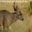

In [19]:
image = next(one)['image']
img = Image.fromarray(image, 'RGB')
img

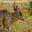

In [20]:
gaussian_noise(img,1)

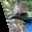

In [182]:
shear_x(img,0)

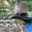

In [183]:
shear_fill_x(img,0)

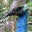

In [184]:
shear_fill_y(img,1)

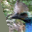

In [185]:
shear_fill_x2(img,0)

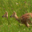

In [52]:
translate_x(img, 0.25)

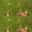

In [53]:
translate_y(img, 0)

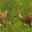

In [54]:
translate_fill_x(img, 0.1)

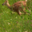

In [55]:
translate_fill_y(img, 0.9)

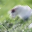

In [7]:
rotate_fill(img,1)

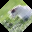

In [8]:
rotate(img, 1)

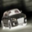

In [16]:
solarize(img,0)

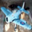

In [666]:
level = 0.5
ImageOps.autocontrast(img)
# Image.blend(img, ImageOps.autocontrast(img), level)

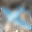

In [667]:
Image.blend(img, img.filter(ImageFilter.BLUR), 0.75)

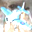

In [668]:
_enhance(img, ImageEnhance.Brightness, 0.75)

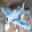

In [669]:
_enhance(img, ImageEnhance.Color, 0.5)

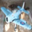

In [670]:
_enhance(img, ImageEnhance.Contrast, 0.5)

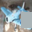

In [671]:
def cutout(x, level):
    """Apply cutout to pil_img at the specified level."""
    size = 1 + int(level * min(x.size) * 0.499)
    img_height, img_width = x.size
    height_loc = np.random.randint(low=0, high=img_height)
    width_loc = np.random.randint(low=0, high=img_width)
    upper_coord = (max(0, height_loc - size // 2), max(0, width_loc - size // 2))
    lower_coord = (min(img_height, height_loc + size // 2), min(img_width, width_loc + size // 2))
    x = x.copy()
    pixels = x.load()  # create the pixel map
#     p = pixels[height_loc,width_loc]
    p = np.array(x)[upper_coord[0]:lower_coord[0], upper_coord[1]:lower_coord[1]]
    p = tuple(np.mean(p,axis=(0,1), dtype=int))
    for i in range(upper_coord[0], lower_coord[0]):  # for every col:
        for j in range(upper_coord[1], lower_coord[1]):  # For every row
            pixels[i, j] = p  # set the color accordingly
    return x
cutout(img, 1)

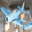

In [672]:
# not good
def cutflip(x, level):
    """Apply cutout to pil_img at the specified level."""
    size = 1 + int(level * min(x.size) * 0.499)
    img_height, img_width = x.size
    height_loc = np.random.randint(low=0, high=img_height)
    width_loc = np.random.randint(low=0, high=img_width)
    upper_coord = (max(0, height_loc - size // 2), max(0, width_loc - size // 2))
    lower_coord = (min(img_height, height_loc + size // 2), min(img_width, width_loc + size // 2))
    y = x.copy()
    px = x.load()  # create the pixel map
    py = y.load()
    for i in range(upper_coord[0], lower_coord[0]):  # for every col:
        for j in range(upper_coord[1], lower_coord[1]):  # For every row
            flipped_i = lower_coord[0] - 1 - (i - upper_coord[0])
#             flipped_j = lower_coord[1] - 1 - (i - upper_coord[1])
            py[i, j] = px[flipped_i, j]  # set the color accordingly
    return y
cutflip(img, 1)

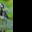

In [739]:
translate_x(img,32)

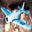

In [679]:
_imageop(img, ImageOps.equalize, 0.9)

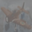

In [678]:
_imageop(img, ImageOps.invert, 0.6)

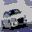

In [10]:
def posterize(x, level):
    level = 1 + int(level * 7.999)
    return ImageOps.posterize(x, level)
posterize(img,0.2)

/tmp/ipykernel_1296966/986413361.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  methods = (Image.ANTIALIAS, Image.BICUBIC, Image.BILINEAR, Image.BOX, Image.HAMMING, Image.NEAREST)


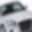

In [11]:
def rescale(x, scale, method):
    s = x.size
    scale *= 0.25
    crop = (scale * s[0], scale * s[1], s[0] * (1 - scale), s[1] * (1 - scale))
    methods = (Image.ANTIALIAS, Image.BICUBIC, Image.BILINEAR, Image.BOX, Image.HAMMING, Image.NEAREST)
    method = methods[int(method * 5.99)]
    return x.crop(crop).resize(x.size, method)
rescale(img, 1, 0.5)

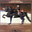

In [725]:
sharpness(img, 1)

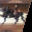

In [726]:
shear_x(img,1)

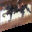

In [724]:
shear_y(img,1)

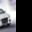

In [14]:
translate_x(img,1)

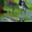

In [746]:
translate_y(img,1)

In [164]:
def sharpness(x, sharpness):
    return _enhance(x, ImageEnhance.Sharpness, sharpness)


def shear_x(x, shear):
    shear = (2 * shear - 1) * 0.3
    return x.transform(x.size, Image.AFFINE, (1, shear, 0, 0, 1, 0))


def shear_y(x, shear):
    shear = (2 * shear - 1) * 0.3
    return x.transform(x.size, Image.AFFINE, (1, 0, 0, shear, 1, 0))

def shear_fill_x(x, shear):
    x = x.convert("RGBA")
    shear = (2 * shear - 1) * 0.3
    sheared = x.transform(x.size, Image.AFFINE, (1, shear, 0, 0, 1, 0))
    x.paste(sheared, mask=sheared)
    return x.convert("RGB")

def shear_fill_y(x, shear):
    x = x.convert("RGBA")
    shear = (2 * shear - 1) * 0.3
    sheared = x.transform(x.size, Image.AFFINE, (1, 0, 0, shear, 1, 0))
    x.paste(sheared, mask=sheared)
    return x.convert("RGB")

def shear_fill_x2(x, shear):
    if shear < 0.5:
        b = np.array(x)[:,0:1].mean(axis=(0,1), keepdims=True)
    else:
        b = np.array(x)[:,x.size[0]-1:x.size[0]].mean(axis=(0,1),keepdims=True)
    b= b.repeat(x.size[0], axis=0).repeat(x.size[1],axis=1)
    b = Image.fromarray(b.astype(np.uint8))
    
    shear = (2 * shear - 1) * 0.3
    sheared = x.convert("RGBA").transform(x.size, Image.AFFINE, (1, shear, 0, 0, 1, 0), fillcolor=0)
    b.paste(sheared, mask=sheared)
    return b
    


def shear_y(x, shear):
    shear = (2 * shear - 1) * 0.3
    return x.transform(x.size, Image.AFFINE, (1, 0, 0, shear, 1, 0))


def smooth(x, level):
    return _filter(x, ImageFilter.SMOOTH, level)


def solarize(x, th):
    th = int(th * 255.999)
    return ImageOps.solarize(x, th)


def translate_x(x, delta):
    delta = (2 * delta - 1) * 0.5 * x.size[0]
    return x.transform(x.size, Image.AFFINE, (1, 0, delta, 0, 1, 0))


def translate_y(x, delta):
    delta = (2 * delta - 1) * 0.5 * x.size[1]
    return x.transform(x.size, Image.AFFINE, (1, 0, 0, 0, 1, delta))

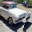

In [61]:
shear_fill_x(img,1)

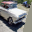

In [60]:
shear_fill_x2(img,1)

In [57]:
Image.fromarray(np.array(img)[0:8,0:16])